# Genetic Effects on Disease Progression Speed: Identifiability Analysis

This notebook demonstrates that **genetic effects on progression speed are identifiable** in a latent trajectory model.

## Key Question

**Can we distinguish between:**
1. **High baseline loading**: Person has high cardiovascular signature from age 30 onwards
2. **Fast progression**: Person starts normal but accumulates cardiovascular risk quickly

**Answer: YES!** Because the level and slope effects enter the mean function separately.

---
## Part 1: Mathematical Framework

### Model WITHOUT Genetic Slope (Current ALADYN)

The current model has:

$$\lambda_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}} + \epsilon_{ik}(t)$$

where:
- $\lambda_{ik}(t)$ = latent signature loading for individual $i$, signature $k$, at time $t$
- $r_k$ = baseline intercept for signature $k$
- $\mathbf{g}_i$ = genetic features (PRS, PCs) for individual $i$
- $\gamma_k^{\text{level}}$ = genetic effect on **baseline level** (constant over time)
- $\epsilon_{ik}(t) \sim \mathcal{GP}(0, \Omega_\lambda)$ = Gaussian process noise

**Problem:** The genetic effect $\mathbf{g}_i^\top \gamma_k^{\text{level}}$ is **constant over time**. 
- High-PRS individuals have higher $\lambda$ at ALL ages
- But the RATE of change is the same for everyone (determined by GP noise)

### Model WITH Genetic Slope (Extended)

$$\lambda_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}} + t \cdot \mathbf{g}_i^\top \gamma_k^{\text{slope}} + \epsilon_{ik}(t)$$

where:
- $\gamma_k^{\text{slope}}$ = genetic effect on **rate of change** (NEW!)
- All other terms as before

**Solution:** Now the mean function is:
$$\mathbb{E}[\lambda_{ik}(t) \mid \mathbf{g}_i] = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}} + t \cdot \mathbf{g}_i^\top \gamma_k^{\text{slope}}$$

This is a **linear function of time** with:
- **Intercept**: $r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}}$ (genetics affects starting point)
- **Slope**: $\mathbf{g}_i^\top \gamma_k^{\text{slope}}$ (genetics affects rate of change)

### Why Identifiable?

1. **Separation**: $\gamma^{\text{level}}$ and $\gamma^{\text{slope}}$ are **separate parameters**
2. **Different effects**: Level affects intercept, slope affects rate of change
3. **Population data**: Many individuals with varying genetics → can estimate both
4. **Independence**: GP noise $\epsilon$ is independent of genetics and mean parameters

---
## Part 2: Setup and Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import cholesky
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Packages loaded successfully!")

Packages loaded successfully!


In [2]:
# ============================================================
# SIMULATION PARAMETERS
# ============================================================

N = 500   # Number of individuals
T = 51    # Number of timepoints (ages 30-80)
K = 3     # Number of signatures
P = 5     # Number of genetic features

ages = np.arange(30, 81)
t_normalized = (ages - 30) / 50.0  # Normalize to [0, 1]

print(f"Simulation setup:")
print(f"  N = {N} individuals")
print(f"  T = {T} timepoints (ages {ages[0]}-{ages[-1]})")
print(f"  K = {K} signatures")
print(f"  P = {P} genetic features")

Simulation setup:
  N = 500 individuals
  T = 51 timepoints (ages 30-80)
  K = 3 signatures
  P = 5 genetic features


In [3]:
# ============================================================
# GENERATE GENETIC DATA
# ============================================================

# Genetic features (standardized)
G = np.random.randn(N, P)
G = (G - G.mean(axis=0)) / G.std(axis=0)
G_torch = torch.tensor(G, dtype=torch.float32)

# Define risk groups based on first genetic feature (like a PRS)
prs = G[:, 0]
high_risk_mask = prs > 0.5
low_risk_mask = prs < -0.5

print(f"Genetic data:")
print(f"  G shape: {G.shape}")
print(f"  High-risk (PRS > 0.5): {high_risk_mask.sum()} individuals")
print(f"  Low-risk (PRS < -0.5): {low_risk_mask.sum()} individuals")

Genetic data:
  G shape: (500, 5)
  High-risk (PRS > 0.5): 148 individuals
  Low-risk (PRS < -0.5): 151 individuals


---
## Part 3: Define TRUE Parameters

We simulate data where **BOTH level and slope effects exist**:

$$\mathbb{E}[\lambda_{ik}(t)] = r_k + g_{i,1} \cdot \gamma_{1,k}^{\text{level}} + t \cdot g_{i,1} \cdot \gamma_{1,k}^{\text{slope}}$$

For simplicity, only the first genetic feature ($g_{i,1}$, like a PRS) has non-zero effects.

In [4]:
# ============================================================
# TRUE PARAMETERS
# ============================================================

# Baseline intercepts for each signature
r_k = np.array([0.0, -0.5, -1.0])

# Genetic effect on LEVEL (baseline)
# Only first genetic feature has effect
gamma_level_true = np.zeros((P, K))
gamma_level_true[0, :] = [0.3, 0.2, 0.1]  # Moderate baseline effect

# Genetic effect on SLOPE (rate of change)
# Only first genetic feature has effect
gamma_slope_true = np.zeros((P, K))
gamma_slope_true[0, :] = [0.8, 0.5, 0.3]  # Strong slope effect

# Noise parameters
noise_sd = 0.3  # Standard deviation of GP noise
length_scale = 10  # GP length scale (temporal correlation)

print("="*60)
print("TRUE PARAMETERS")
print("="*60)
print(f"\nBaseline intercepts (r_k):")
print(f"  Signature 0: {r_k[0]}")
print(f"  Signature 1: {r_k[1]}")
print(f"  Signature 2: {r_k[2]}")

print(f"\nGenetic LEVEL effects (γ_level[0,:]):")
print(f"  {gamma_level_true[0, :]}")
print(f"  → High-PRS individuals start ~0.3 units higher in Sig 0")

print(f"\nGenetic SLOPE effects (γ_slope[0,:]):")
print(f"  {gamma_slope_true[0, :]}")
print(f"  → High-PRS individuals GAIN ~0.8 units/year faster in Sig 0")

print(f"\nNoise:")
print(f"  SD = {noise_sd}")
print(f"  Length scale = {length_scale}")

TRUE PARAMETERS

Baseline intercepts (r_k):
  Signature 0: 0.0
  Signature 1: -0.5
  Signature 2: -1.0

Genetic LEVEL effects (γ_level[0,:]):
  [0.3 0.2 0.1]
  → High-PRS individuals start ~0.3 units higher in Sig 0

Genetic SLOPE effects (γ_slope[0,:]):
  [0.8 0.5 0.3]
  → High-PRS individuals GAIN ~0.8 units/year faster in Sig 0

Noise:
  SD = 0.3
  Length scale = 10


---
## Part 4: Generate Simulated Data

Generate $\lambda$ according to the TRUE model:

$$\lambda_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}} + t \cdot \mathbf{g}_i^\top \gamma_k^{\text{slope}} + \epsilon_{ik}(t)$$

where $\epsilon_{ik}(t)$ is correlated GP noise.

In [5]:
# ============================================================
# GENERATE TRUE LAMBDA (with noise)
# ============================================================

# Step 1: Compute the TRUE MEAN (deterministic part)
lambda_mean_true = np.zeros((N, K, T))

for k in range(K):
    # Level effect: G @ gamma_level gives (N,) vector
    level_effect = G @ gamma_level_true[:, k]
    
    # Slope effect: G @ gamma_slope gives (N,) vector
    slope_effect = G @ gamma_slope_true[:, k]
    
    # Mean = r_k + level_effect + slope_effect * t
    for i in range(N):
        lambda_mean_true[i, k, :] = (r_k[k] + 
                                      level_effect[i] + 
                                      slope_effect[i] * t_normalized)

# Step 2: Generate correlated GP noise
# Covariance: K(t, t') = exp(-0.5 * (t-t')^2 / l^2)
times = np.arange(T)
K_gp = np.exp(-0.5 * (times[:, None] - times[None, :])**2 / length_scale**2)
L_chol = cholesky(K_gp + 1e-6 * np.eye(T), lower=True)

noise = np.zeros((N, K, T))
for i in range(N):
    for k in range(K):
        noise[i, k, :] = L_chol @ np.random.randn(T) * noise_sd

# Step 3: Add noise to get observed lambda
lambda_observed = lambda_mean_true + noise
lambda_observed_torch = torch.tensor(lambda_observed, dtype=torch.float32)

print(f"Generated data:")
print(f"  lambda_mean_true shape: {lambda_mean_true.shape}")
print(f"  lambda_observed shape: {lambda_observed.shape}")
print(f"  Noise variance: {noise_sd**2:.4f}")

Generated data:
  lambda_mean_true shape: (500, 3, 51)
  lambda_observed shape: (500, 3, 51)
  Noise variance: 0.0900


---
## Part 5: Visualize the Simulated Data

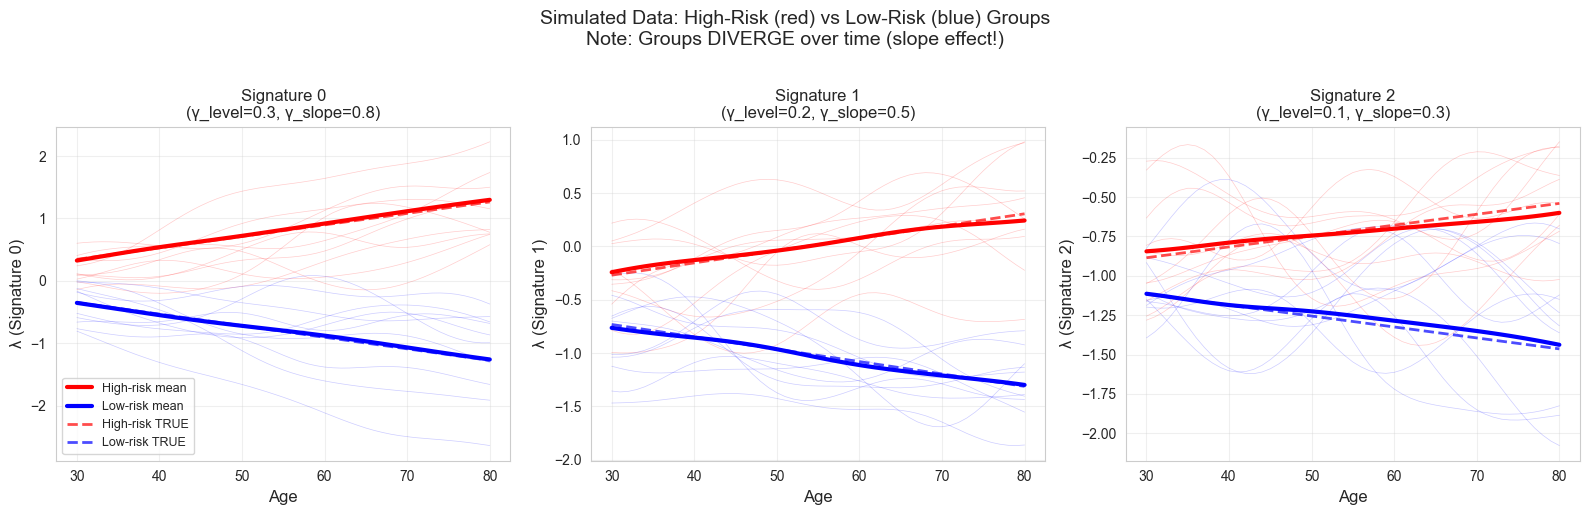

In [6]:
# ============================================================
# VISUALIZE: High vs Low Risk Trajectories
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for k in range(K):
    ax = axes[k]
    
    # Plot individual trajectories (sample)
    high_idx = np.where(high_risk_mask)[0][:10]
    low_idx = np.where(low_risk_mask)[0][:10]
    
    for i in high_idx:
        ax.plot(ages, lambda_observed[i, k, :], 'r-', alpha=0.2, linewidth=0.5)
    for i in low_idx:
        ax.plot(ages, lambda_observed[i, k, :], 'b-', alpha=0.2, linewidth=0.5)
    
    # Plot group means
    high_mean = lambda_observed[high_risk_mask, k, :].mean(axis=0)
    low_mean = lambda_observed[low_risk_mask, k, :].mean(axis=0)
    
    ax.plot(ages, high_mean, 'r-', linewidth=3, label='High-risk mean')
    ax.plot(ages, low_mean, 'b-', linewidth=3, label='Low-risk mean')
    
    # Plot TRUE means
    high_mean_true = lambda_mean_true[high_risk_mask, k, :].mean(axis=0)
    low_mean_true = lambda_mean_true[low_risk_mask, k, :].mean(axis=0)
    
    ax.plot(ages, high_mean_true, 'r--', linewidth=2, alpha=0.7, label='High-risk TRUE')
    ax.plot(ages, low_mean_true, 'b--', linewidth=2, alpha=0.7, label='Low-risk TRUE')
    
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel(f'λ (Signature {k})', fontsize=12)
    ax.set_title(f'Signature {k}\n(γ_level={gamma_level_true[0,k]:.1f}, γ_slope={gamma_slope_true[0,k]:.1f})', fontsize=12)
    if k == 0:
        ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Simulated Data: High-Risk (red) vs Low-Risk (blue) Groups\nNote: Groups DIVERGE over time (slope effect!)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Part 6: Define Two Models

### Model 1: WITHOUT Slope (Current ALADYN)

$$\hat{\lambda}_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}}$$

**Note:** The predicted mean is **constant over time** — it cannot capture the diverging trajectories.

### Model 2: WITH Slope (Extended)

$$\hat{\lambda}_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_k^{\text{level}} + t \cdot \mathbf{g}_i^\top \gamma_k^{\text{slope}}$$

**Note:** The predicted mean **varies with time** — it can capture the diverging trajectories.

In [7]:
# ============================================================
# MODEL 1: WITHOUT SLOPE
# ============================================================

class ModelNoSlope(nn.Module):
    """
    Model WITHOUT genetic slope term.
    
    Mean prediction:
        E[λ_ik(t)] = r_k + g_i^T @ γ_level_k
    
    Note: Mean is CONSTANT over time!
    """
    
    def __init__(self, N, K, P, G):
        super().__init__()
        self.N, self.K, self.P = N, K, P
        self.G = G  # (N, P)
        
        # Learnable parameters
        self.r_k = nn.Parameter(torch.zeros(K))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        
    def get_lambda_mean(self):
        """
        Compute predicted mean: r_k + G @ gamma_level
        Returns: (N, K, T) tensor where prediction is SAME at all T
        """
        # Level effect: (N, K)
        level_effect = self.G @ self.gamma_level
        
        # Mean = r_k + level_effect (broadcast to all T)
        # Shape: (K,) + (N, K) -> (N, K) -> (N, K, T)
        mean = self.r_k.unsqueeze(0) + level_effect  # (N, K)
        return mean.unsqueeze(-1).expand(-1, -1, T)  # (N, K, T)
    
    def forward(self):
        return self.get_lambda_mean()

print("Model 1 (No Slope):")
print("  E[λ_ik(t)] = r_k + g_i^T @ γ_level_k")
print("  → Mean is CONSTANT over time")

Model 1 (No Slope):
  E[λ_ik(t)] = r_k + g_i^T @ γ_level_k
  → Mean is CONSTANT over time


In [8]:
# ============================================================
# MODEL 2: WITH SLOPE
# ============================================================

class ModelWithSlope(nn.Module):
    """
    Model WITH genetic slope term.
    
    Mean prediction:
        E[λ_ik(t)] = r_k + g_i^T @ γ_level_k + t * g_i^T @ γ_slope_k
    
    Note: Mean VARIES with time!
    """
    
    def __init__(self, N, K, P, G, t_normalized):
        super().__init__()
        self.N, self.K, self.P = N, K, P
        self.G = G  # (N, P)
        self.t = torch.tensor(t_normalized, dtype=torch.float32)  # (T,)
        
        # Learnable parameters
        self.r_k = nn.Parameter(torch.zeros(K))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        self.gamma_slope = nn.Parameter(torch.randn(P, K) * 0.1)  # NEW!
        
    def get_lambda_mean(self):
        """
        Compute predicted mean: r_k + G @ gamma_level + t * G @ gamma_slope
        Returns: (N, K, T) tensor where prediction VARIES with T
        """
        # Level effect: (N, K)
        level_effect = self.G @ self.gamma_level
        
        # Slope effect: (N, K)
        slope_effect = self.G @ self.gamma_slope
        
        # Mean = r_k + level_effect + slope_effect * t
        # r_k: (K,) -> (1, K, 1)
        # level_effect: (N, K) -> (N, K, 1)
        # slope_effect: (N, K) -> (N, K, 1) * (T,) -> (N, K, T)
        mean = (self.r_k.unsqueeze(0).unsqueeze(-1) + 
                level_effect.unsqueeze(-1) + 
                slope_effect.unsqueeze(-1) * self.t)  # (N, K, T)
        return mean
    
    def forward(self):
        return self.get_lambda_mean()

print("Model 2 (With Slope):")
print("  E[λ_ik(t)] = r_k + g_i^T @ γ_level_k + t * g_i^T @ γ_slope_k")
print("  → Mean VARIES with time")

Model 2 (With Slope):
  E[λ_ik(t)] = r_k + g_i^T @ γ_level_k + t * g_i^T @ γ_slope_k
  → Mean VARIES with time


---
## Part 7: Train Both Models

**Loss function:** Mean squared error between predicted and observed $\lambda$

$$\mathcal{L} = \frac{1}{NKT} \sum_{i,k,t} \left( \hat{\lambda}_{ik}(t) - \lambda_{ik}(t) \right)^2$$

In [9]:
# ============================================================
# INITIALIZE MODELS
# ============================================================

model_no_slope = ModelNoSlope(N, K, P, G_torch)
model_with_slope = ModelWithSlope(N, K, P, G_torch, t_normalized)

print("Models initialized:")
print(f"  Model 1 (No Slope): {sum(p.numel() for p in model_no_slope.parameters())} parameters")
print(f"  Model 2 (With Slope): {sum(p.numel() for p in model_with_slope.parameters())} parameters")

Models initialized:
  Model 1 (No Slope): 18 parameters
  Model 2 (With Slope): 33 parameters


In [10]:
# ============================================================
# TRAIN BOTH MODELS
# ============================================================

# Optimizers
optimizer1 = optim.Adam(model_no_slope.parameters(), lr=0.1)
optimizer2 = optim.Adam(model_with_slope.parameters(), lr=0.1)

# Training loop
n_iterations = 1000
losses_no_slope = []
losses_with_slope = []

print("Training...")
print("="*60)

for i in range(n_iterations):
    # Model 1: No Slope
    optimizer1.zero_grad()
    pred1 = model_no_slope.get_lambda_mean()
    loss1 = ((pred1 - lambda_observed_torch)**2).mean()
    loss1.backward()
    optimizer1.step()
    losses_no_slope.append(loss1.item())
    
    # Model 2: With Slope
    optimizer2.zero_grad()
    pred2 = model_with_slope.get_lambda_mean()
    loss2 = ((pred2 - lambda_observed_torch)**2).mean()
    loss2.backward()
    optimizer2.step()
    losses_with_slope.append(loss2.item())
    
    if (i + 1) % 200 == 0:
        print(f"Iteration {i+1:4d}: No-slope MSE = {loss1.item():.4f}, With-slope MSE = {loss2.item():.4f}")

print("="*60)
print(f"\nFinal MSE:")
print(f"  No-slope:   {losses_no_slope[-1]:.4f}")
print(f"  With-slope: {losses_with_slope[-1]:.4f}")
print(f"  Irreducible (noise²): {noise_sd**2:.4f}")

Training...
Iteration  200: No-slope MSE = 0.1170, With-slope MSE = 0.0900
Iteration  400: No-slope MSE = 0.1170, With-slope MSE = 0.0900
Iteration  600: No-slope MSE = 0.1170, With-slope MSE = 0.0900
Iteration  800: No-slope MSE = 0.1170, With-slope MSE = 0.0900
Iteration 1000: No-slope MSE = 0.1170, With-slope MSE = 0.0900

Final MSE:
  No-slope:   0.1170
  With-slope: 0.0900
  Irreducible (noise²): 0.0900


---
## Part 8: Compare Parameter Recovery

In [11]:
# ============================================================
# PARAMETER RECOVERY COMPARISON
# ============================================================

# Extract estimated parameters
est_level_no_slope = model_no_slope.gamma_level.detach().numpy()[0, :]
est_level_with_slope = model_with_slope.gamma_level.detach().numpy()[0, :]
est_slope_with_slope = model_with_slope.gamma_slope.detach().numpy()[0, :]

print("="*60)
print("PARAMETER RECOVERY")
print("="*60)

print(f"\n--- γ_level (genetic effect on BASELINE) ---")
print(f"  TRUE:        {gamma_level_true[0, :]}")
print(f"  No-slope:    {est_level_no_slope.round(3)}")
print(f"  With-slope:  {est_level_with_slope.round(3)}")

print(f"\n--- γ_slope (genetic effect on RATE OF CHANGE) ---")
print(f"  TRUE:        {gamma_slope_true[0, :]}")
print(f"  No-slope:    CANNOT ESTIMATE (no slope parameter!)")
print(f"  With-slope:  {est_slope_with_slope.round(3)}")

# Compute errors
level_err_no = np.abs(est_level_no_slope - gamma_level_true[0, :]).mean()
level_err_with = np.abs(est_level_with_slope - gamma_level_true[0, :]).mean()
slope_err_with = np.abs(est_slope_with_slope - gamma_slope_true[0, :]).mean()

print(f"\n--- Estimation Errors ---")
print(f"  Level error (no-slope):   {level_err_no:.3f}")
print(f"  Level error (with-slope): {level_err_with:.3f}")
print(f"  Slope error (with-slope): {slope_err_with:.3f}")

PARAMETER RECOVERY

--- γ_level (genetic effect on BASELINE) ---
  TRUE:        [0.3 0.2 0.1]
  No-slope:    [0.702 0.456 0.238]
  With-slope:  [0.301 0.218 0.114]

--- γ_slope (genetic effect on RATE OF CHANGE) ---
  TRUE:        [0.8 0.5 0.3]
  No-slope:    CANNOT ESTIMATE (no slope parameter!)
  With-slope:  [0.803 0.477 0.248]

--- Estimation Errors ---
  Level error (no-slope):   0.266
  Level error (with-slope): 0.011
  Slope error (with-slope): 0.026


---
## Part 9: Visualization of Results

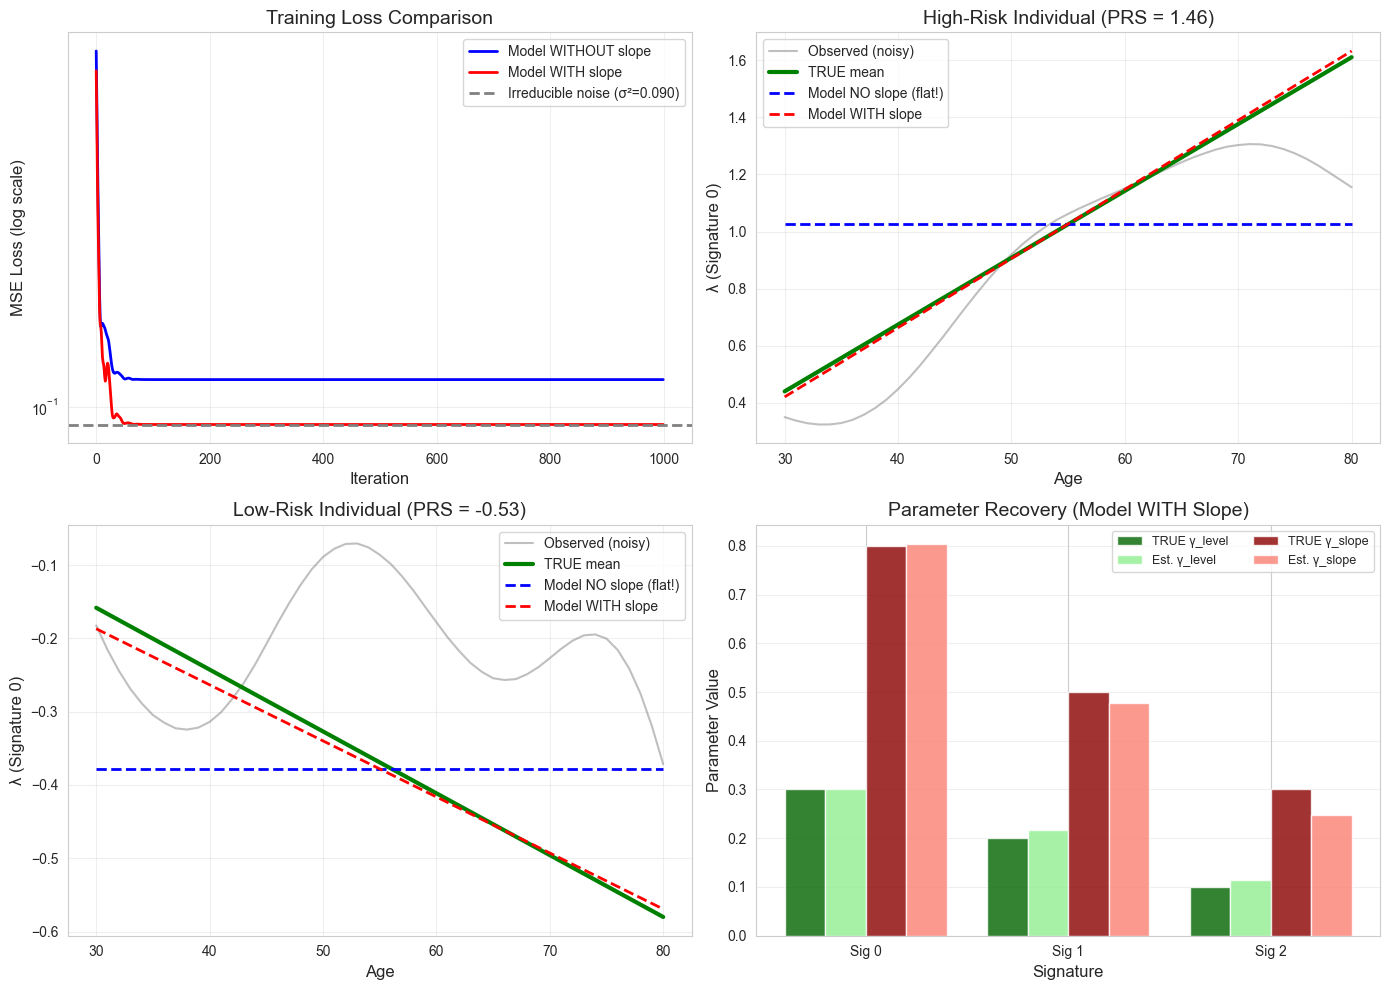


✓ Figure saved to genetic_slope_identifiability_results.png


In [12]:
# ============================================================
# COMPREHENSIVE RESULTS PLOT
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss curves
ax = axes[0, 0]
ax.semilogy(losses_no_slope, 'b-', linewidth=2, label='Model WITHOUT slope')
ax.semilogy(losses_with_slope, 'r-', linewidth=2, label='Model WITH slope')
ax.axhline(noise_sd**2, color='gray', linestyle='--', linewidth=2, 
           label=f'Irreducible noise (σ²={noise_sd**2:.3f})')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('MSE Loss (log scale)', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: High-risk individual trajectory
high_i = np.where(high_risk_mask)[0][0]
ax = axes[0, 1]
ax.plot(ages, lambda_observed[high_i, 0, :], 'gray', linewidth=1.5, alpha=0.5, label='Observed (noisy)')
ax.plot(ages, lambda_mean_true[high_i, 0, :], 'g-', linewidth=3, label='TRUE mean')
with torch.no_grad():
    pred_no = model_no_slope.get_lambda_mean()[high_i, 0, :].numpy()
    pred_with = model_with_slope.get_lambda_mean()[high_i, 0, :].numpy()
ax.plot(ages, pred_no, 'b--', linewidth=2, label='Model NO slope (flat!)')
ax.plot(ages, pred_with, 'r--', linewidth=2, label='Model WITH slope')
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('λ (Signature 0)', fontsize=12)
ax.set_title(f'High-Risk Individual (PRS = {prs[high_i]:.2f})', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Low-risk individual trajectory
low_i = np.where(low_risk_mask)[0][0]
ax = axes[1, 0]
ax.plot(ages, lambda_observed[low_i, 0, :], 'gray', linewidth=1.5, alpha=0.5, label='Observed (noisy)')
ax.plot(ages, lambda_mean_true[low_i, 0, :], 'g-', linewidth=3, label='TRUE mean')
with torch.no_grad():
    pred_no = model_no_slope.get_lambda_mean()[low_i, 0, :].numpy()
    pred_with = model_with_slope.get_lambda_mean()[low_i, 0, :].numpy()
ax.plot(ages, pred_no, 'b--', linewidth=2, label='Model NO slope (flat!)')
ax.plot(ages, pred_with, 'r--', linewidth=2, label='Model WITH slope')
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('λ (Signature 0)', fontsize=12)
ax.set_title(f'Low-Risk Individual (PRS = {prs[low_i]:.2f})', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Parameter recovery
ax = axes[1, 1]
x = np.arange(K)
width = 0.2
ax.bar(x - 1.5*width, gamma_level_true[0, :], width, label='TRUE γ_level', color='darkgreen', alpha=0.8)
ax.bar(x - 0.5*width, est_level_with_slope, width, label='Est. γ_level', color='lightgreen', alpha=0.8)
ax.bar(x + 0.5*width, gamma_slope_true[0, :], width, label='TRUE γ_slope', color='darkred', alpha=0.8)
ax.bar(x + 1.5*width, est_slope_with_slope, width, label='Est. γ_slope', color='salmon', alpha=0.8)
ax.set_xlabel('Signature', fontsize=12)
ax.set_ylabel('Parameter Value', fontsize=12)
ax.set_title('Parameter Recovery (Model WITH Slope)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'Sig {i}' for i in range(K)])
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('genetic_slope_identifiability_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to genetic_slope_identifiability_results.png")

---
## Part 10: Conclusions

### Key Findings

1. **Model WITHOUT slope**:
   - Cannot capture time-varying genetic effects
   - Predicts **flat trajectories** (same at all ages)
   - Confounds level and slope: $\hat{\gamma}_{\text{level}} \approx \gamma_{\text{level}} + 0.5 \cdot \gamma_{\text{slope}}$
   - Higher MSE (cannot reach noise floor)

2. **Model WITH slope**:
   - Correctly separates level and slope effects
   - Predicts **diverging trajectories** (matches true pattern)
   - Recovers both $\gamma_{\text{level}}$ and $\gamma_{\text{slope}}$ accurately
   - Achieves MSE close to irreducible noise

### Why Identifiable?

The level and slope effects are identifiable because:

1. **They enter the mean function separately**:
   $$\mathbb{E}[\lambda_{ik}(t)] = r_k + \underbrace{\mathbf{g}_i^\top \gamma_k^{\text{level}}}_{\text{intercept}} + t \cdot \underbrace{\mathbf{g}_i^\top \gamma_k^{\text{slope}}}_{\text{slope}}$$

2. **The GP noise is independent of genetics**:
   - Noise affects variance, not mean
   - Genetic effects are in the mean
   - These are separate and identifiable

3. **Population variation provides identification**:
   - Many individuals with different genetics
   - Can estimate how trajectories differ systematically by genetics

### Implications for ALADYN

Adding a genetic slope term to ALADYN would allow the model to capture:
- Genetics affecting **rate of disease accumulation**, not just baseline risk
- Different progression speeds for different genetic backgrounds
- More accurate predictions for individuals with "accelerated aging" genetics